# Analyses of training-outcomes

In [ ]:
import os
import bioencoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
# os.chdir(r"D:\git-repos\mluerig\workshop-nau-bioencoder")
os.chdir(r"/home/mlurig/git-repos/workshop-nau-bioencoder")
# os.chdir(r"/scratch/mdl458/workshop-nau-bioencoder")

In [ ]:
bioencoder.configure(root_dir=r"bioencoder_wd", run_name="v1", create=True)

### Run inference and collect predictions

Run `bioencoder.inference` on every image in the validation set and collect predictions in a nested dictionary for later analysis.

- Source directory: `bioencoder_wd/data/v1/val/`
- Output structure: `results[true_class][image_name] -> predicted_class` (string)
- Config used: `configs/inference.yml`

These predictions will be used to compute both raw and normalized confusion matrices.

In [ ]:
results = dict()
img_dir = r"bioencoder_wd/data/v1/val/"
for class_name in os.listdir(img_dir):
    class_dir = os.path.join(img_dir, class_name)
    results[class_name] = dict()
    for image_name in os.listdir(class_dir):
        path = os.path.join(class_dir, image_name)
        result = bioencoder.inference(config_path="configs/inference.yml", image=path)
        print(f"class: {class_name}; prediction: {result}")
        results[class_name][image_name] = result

### Confusion Matrix

Compute a confusion matrix across all predictions in `results`. We assume `results[true_class][image_name]` is the predicted class (string).

In [ ]:
# Build y_true and y_pred from `results`
y_true = []
y_pred = []
for true_class, file_map in results.items():
    for _img_name, predicted_class in file_map.items():
        y_true.append(true_class)
        y_pred.append(predicted_class)

labels = sorted(set(y_true) | set(y_pred))
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(max(6, len(labels)*0.5), max(6, len(labels)*0.5)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Compute and plot row-wise normalized confusion matrix
fig, ax = plt.subplots(figsize=(max(6, len(labels)*0.5), max(6, len(labels)*0.5)))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    normalize="true",
    display_labels=labels,
    cmap="Blues",
    ax=ax,
    xticks_rotation=90,
    colorbar=False,
    values_format=".1f",  # show one decimal for normalized values
)
ax.set_title("Confusion Matrix (Normalized per True Class)")
plt.tight_layout()
plt.show()

In [ ]:
df_emb = pd.read_csv(r"data/embeddings_v1.csv")
df_feat = pd.read_csv(r"data_raw/data_feat_junonia.csv")


In [ ]:
df_emb

### PCA on embeddings with supplementary variables

We merge embeddings (`df_emb`) with features (`df_feat`) via `df_emb.image_name == df_feat.mask_name`, run PCA on the embedding vectors, and relate features to PCs via correlations.

In [120]:
# Standardize embeddings (main variables)
X_main = df_emb.iloc[:,3:].to_numpy(dtype=float)
X_main_scaled = StandardScaler().fit_transform(X_main)

# PCA on standardized embeddings (keep first 2 for plotting/relations)
pca = PCA(n_components=2, random_state=42)
pc_scores = pca.fit_transform(X_main_scaled)

# Prepare plot DataFrame with identifiers
df_plot = df_emb.iloc[:,:3].copy()
df_plot[["Dim1", "Dim2"]] = pc_scores

# supporting variables: image features
df_supp = df_feat[df_feat["mask_name"].isin(df_emb["image_name"])].copy()
feature_cols = df_supp.columns[1:].tolist()
X_support = df_supp[feature_cols].to_numpy(dtype=float)
X_support_scaled = StandardScaler().fit_transform(X_support)

# Align PC rows to df_supp order via mask_name/image_name
pc_df = pd.DataFrame(pc_scores, index=df_emb["image_name"], columns=["Dim1", "Dim2"])
pc12_aligned = pc_df.loc[df_supp["mask_name"]].to_numpy(dtype=float)
pc12_scaled = StandardScaler().fit_transform(pc12_aligned)

# Supplementary variable loadings as correlations with PC axes
supp_loadings = (pc12_scaled.T @ X_support_scaled) / (X_support_scaled.shape[0] - 1)
df_supp_loadings = pd.DataFrame(
    supp_loadings.T, columns=["Dim1", "Dim2"], index=feature_cols
).reset_index().rename(columns={"index": "feature"})

# Report variance explained for the two components
var_explained = pca.explained_variance_ratio_[:2]
print(f"Explained variance: PC1={var_explained[0]:.2%}, PC2={var_explained[1]:.2%}")

Explained variance: PC1=9.52%, PC2=8.12%


In [119]:
df_supp_loadings

,feature,Dim1,Dim2
0,feat_color_moments_blue_mean,0.447912,-0.184673
1,feat_color_moments_blue_var,-0.053753,0.449418
2,feat_color_moments_blue_skew,-0.288098,-0.022237
3,feat_color_moments_blue_kurt,0.013279,-0.194609
4,feat_color_moments_blue_median,0.518170,-0.330452
...,...,...,...
151,feat_color_dft_blyl_hor,0.213098,-0.154519
152,feat_color_dft_blyl_low,-0.002470,-0.175674
153,feat_color_dft_blyl_meanmag,0.218747,-0.178676
154,feat_color_dft_blyl_stdmag,-0.300781,0.001688


/tmp/ipykernel_1070548/928078292.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("jet", n)


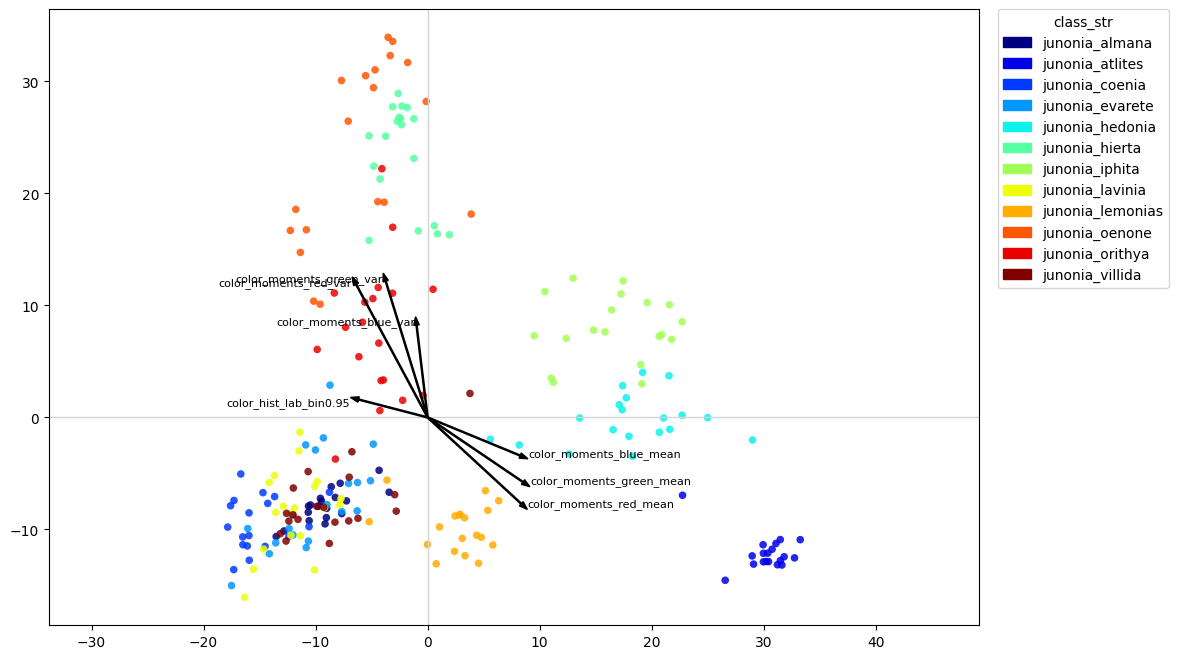

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))

# Color by fixed categorical column 'class_str' using discrete jet colormap
ser = df_emb["class_str"].astype(str)
cats = pd.Categorical(ser)
labels = list(cats.categories)
n = max(1, len(labels))
cmap = plt.cm.get_cmap("jet", n)
idx = cats.codes
ax.scatter(df_plot['Dim1'], df_plot['Dim2'], c=idx, cmap=cmap, s=30, alpha=0.85, edgecolors='none')
handles = [mpl.patches.Patch(color=cmap(i), label=lab) for i, lab in enumerate(labels)]
ax.legend(handles=handles, title="class_str", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

# Axes lines and aspect ratio
ax.axhline(0, color='lightgray', lw=1)
ax.axvline(0, color='lightgray', lw=1)
ax.set_aspect('equal', adjustable='datalim')

amod = 20
feature_subset = ["blue_mean", "red_mean", "green_mean", "red_var", "blue_var", "green_var", "hist_lab_bin0.95"]
for _, row in df_supp_loadings.iterrows():
    load_x = row["Dim1"]
    load_y = row["Dim2"]
    feature = row["feature"]
    if isinstance(feature, str) and not any(term in feature for term in feature_subset):
        continue
    ax.arrow(0, 0, load_x*amod, load_y*amod, color="black", alpha=1, width=0.1, head_width=0.5, length_includes_head=True, zorder=4)
    ax.text(load_x*amod, load_y*amod, str(feature)[5:], color="black", fontsize=8, zorder=5,
            # bbox=dict(facecolor="white", alpha=1, edgecolor="black", linewidth=0.5, boxstyle="Round"),
            ha='right' if load_x < 0 else 'left', va='bottom' if load_y < 0 else 'top')